<h2> Лабораторная 3 </h2>
<h3> Предварительный, корреляционный и регрессионный анализ неоднородных данных </h3>

In [1]:
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn import datasets
from sklearn.cluster import KMeans
from statistics import correlation
from scipy.stats import norm, skew, kurtosis, shapiro, chisquare, gaussian_kde, kstest, ttest_ind, spearmanr
import statsmodels.api as sm

Подгрузили необходимый dataset, создали dataframe с необходимыми нам видами ириса "setosa" и "virginica".

In [2]:
ds = datasets.load_iris()

ext_target = ds.target[:, None]
df = pd.DataFrame(
    np.concatenate((ds.data, ds.target_names[ext_target]), axis=1),
    columns=ds.feature_names + ['target_name'])

df = df.loc[df['target_name'] != 'versicolor'].reset_index(drop=True)

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_name
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
95,6.7,3.0,5.2,2.3,virginica
96,6.3,2.5,5.0,1.9,virginica
97,6.5,3.0,5.2,2.0,virginica
98,6.2,3.4,5.4,2.3,virginica


<h3> Предварительный анализ </h3>

Проведем предварительный анализа для переменной SEPALWID

In [3]:
sepalwid_df = df[['sepal width (cm)', 'target_name']]
sepalwid_df

,sepal width (cm),target_name
0,3.5,setosa
1,3.0,setosa
2,3.2,setosa
3,3.1,setosa
4,3.6,setosa
...,...,...
95,3.0,virginica
96,2.5,virginica
97,3.0,virginica
98,3.4,virginica


In [4]:
sepalwid = sepalwid_df['sepal width (cm)'].astype(float)

sepalwid

0     3.5
1     3.0
2     3.2
3     3.1
4     3.6
     ... 
95    3.0
96    2.5
97    3.0
98    3.4
99    3.0
Name: sepal width (cm), Length: 100, dtype: float64

Выдвинем гипотезу о нормальности распределения нашей переменной. Для проверки этой гипотезы первым делом построим гистограмму распределения.

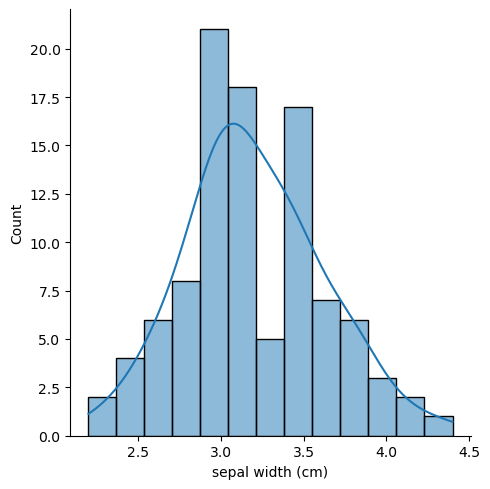

In [5]:
sns.displot(sepalwid, kde=True)

plt.show()

На гистограмме видны горбы, однако по ядерной оценке видно, что наша гистограмма весомо не отличается от гистограммы нормального распределения, что позволяет нам не отклонять гипотезу о нормальности распределения. 

Следующим этапом станет проверка критериев 
+ Колмогорова-Смирнова, 
+ Шапиро-Уилка
+ х^2-Пирсона

In [6]:
print(kstest(sepalwid, 'norm'))
print(scipy.stats.shapiro(sepalwid))
print(scipy.stats.chisquare(sepalwid))

KstestResult(statistic=0.9860965524865014, pvalue=4.104688155544011e-186, statistic_location=2.2, statistic_sign=-1)
ShapiroResult(statistic=0.9852025508880615, pvalue=0.3284207880496979)
Power_divergenceResult(statistic=5.401405810684162, pvalue=1.0)


Из критериев видно, что единственным критерием, который отклоняет гипотезу о нормальности распределения, является критерий Колмогорова-Смирнова(p-value = 4.104688155544011e-186 < 0.05). Однако оставшиеся критерии позволяют не отклонять гипотезу о нормальности.

Проведем анализ дискриптивных статистик.

In [7]:
describe = pd.DataFrame(pd.concat([sepalwid.describe(),
                        pd.Series(sepalwid.median(), index=['median']),
                        pd.Series(sepalwid.mode().to_string(index=False), index = ['mode']),
                        pd.Series(sepalwid.skew(), index=['skewness']),
                        pd.Series(sepalwid.kurt(), index=['kurtosis'])])).T

describe

,count,mean,std,min,25%,50%,75%,max,median,mode,skewness,kurtosis
0,100.0,3.201,0.417906,2.2,3.0,3.2,3.425,4.4,3.2,3.0,0.283451,0.1194


Отсюда видно, что мода, медиана и среднее имеют близкие значения, а медиана и среднее практически равны. Значения выборки лежат в интервале 2.2 - 3.2. Значение коэффициента ассиметрии равно 0.283451, что в целом небольшое значение, свидетельствующее об отклонении выборки влево. Также из таблицы можно увидеть, что выборка обладает небольшим по значению положительным коэффициентом эксцесса, что говорит о том, что выборка имеет более острую вершину.

Построим график "ящик с усами".

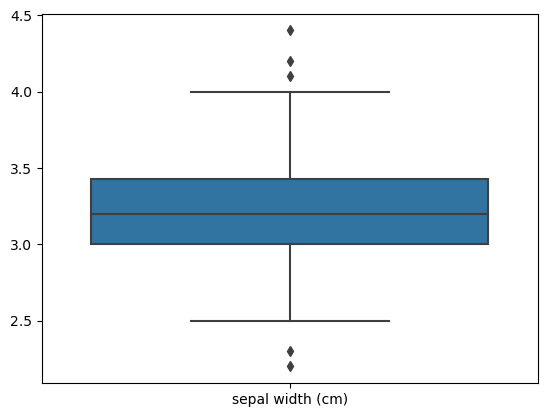

In [8]:
sns.boxplot(pd.DataFrame(sepalwid))

plt.show()

Отсюда видно, что он достаточно симметричен для того, чтобы не отклонять гипотезу о нормальности распределения. Однако заметны некоторые аномальные значения, находящиеся за пределами "усов". Это не является весомой причиной для отклонения гипотезы о нормальности. 

Построим график "квантиль-квантиль".

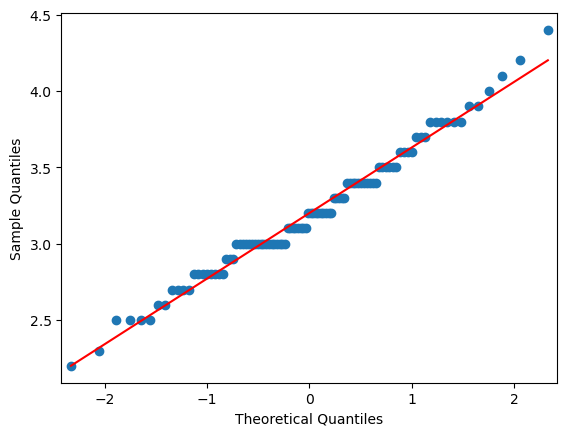

In [9]:
fig = sm.qqplot(sepalwid, line='r')

plt.show()

На этом графике видно, что значения выборки близки к линии нормального распределения, но на концах заметны некоторые отклонения, которые также были замечены и на графике "ящик с усами".

### Корреляционный анализ

Исследуем связь значения случайной величины SEPALWID с остальными случайными величинами.
Для того чтобы увидеть общую картину построим матрицу диаграмм рассеяния.


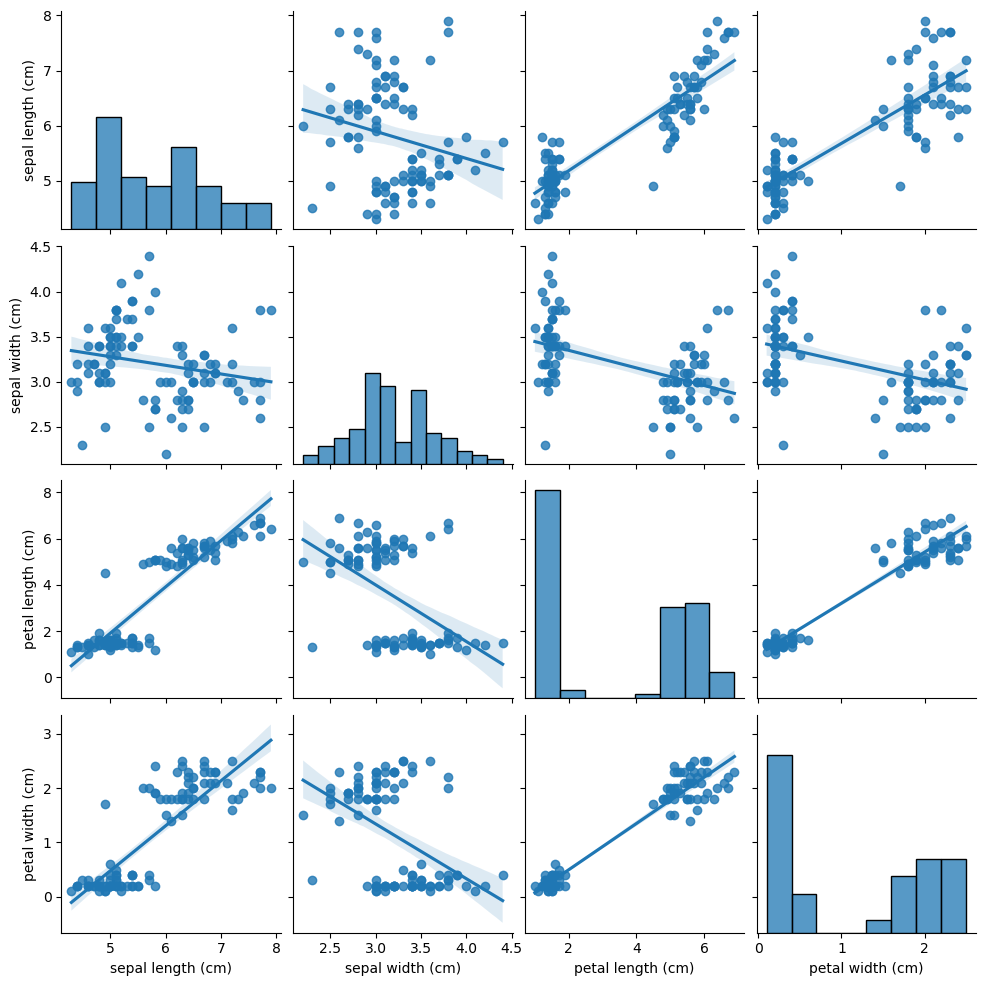

In [10]:
sns.pairplot(df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].astype(float), kind='reg')

plt.show()

#### Корреляция между SEPALWID и SEPALLEN

Рассмотрим зависимость между переменными SEPALWID и SEPALLEN.

Для этого сначала построим диаграмму рассеяния для этих двух переменных.

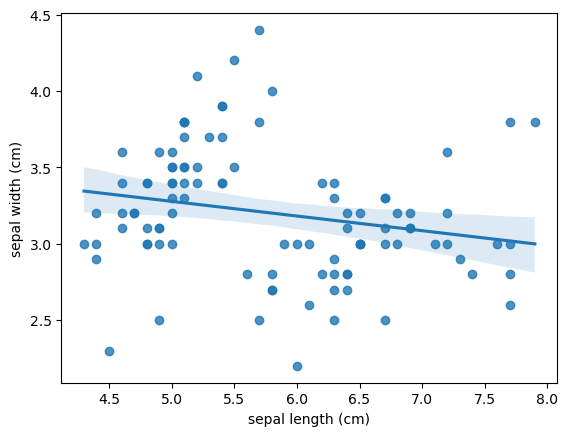

In [11]:
sepallen = df['sepal length (cm)'].astype(float)

sns.regplot(x = sepallen, y = sepalwid)

plt.show()

Сильной зависимости на графике не наблюдается, однако необходимо всё же выяснить, какова корреляция между ними, для этого можно использовать следующее:
+ коэффициент корреляции Пирсона - в случае нормальности распределения обеих переменных;
+ коэффициент корреляции Спирмена - в случае нарушения нормальности распределения хотя бы одной из переменных.

В предварительном анализе переменной SEPALWID мы уже подтвердили гипотезу о нормальности её распределения. Поэтому сразу перейдем к проверке на нормальность переменной SEPALLEN. Для этого построим гистограмму.

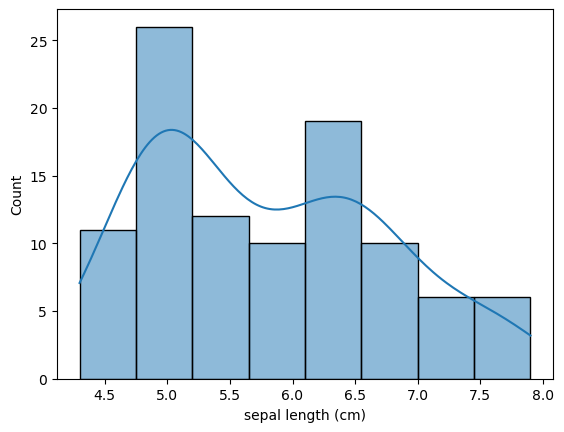

In [12]:
sns.histplot(sepallen, kde=True)

plt.show()

На графике видна ассиметрия и видны два "горба", которые указывают на то, что у распределния переменной SEPALLEN нарушается свойство унимодулярности, что уже позволяет опровергнуть нашу гипотезу. Чтобы сделать более точный вывод, построим график "квантиль-квантиль".

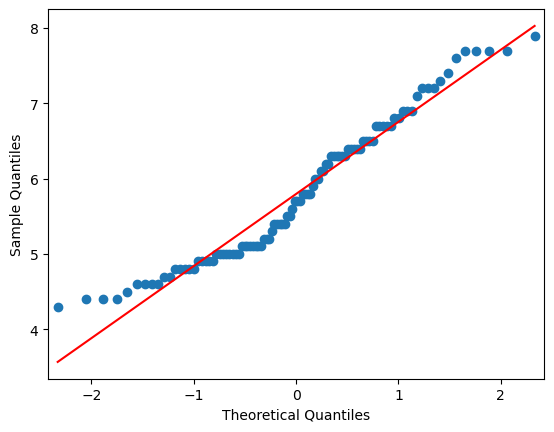

In [13]:
fig = sm.qqplot(sepallen, line='r')

plt.show()

Видно, что вдоль всей линии нормального распределения так или иначе присуствуют отклонения значений SEPALLEN от нее.

Для окончательного подтверждения гипотезу о том, что переменная не имеет нормального распределения, рассмотрим критерии
+ Колмогорова-Смирнова, 
+ Шапиро-Уилка
+ х^2-Пирсона

In [14]:
print(kstest(sepallen, 'norm'))
print(scipy.stats.shapiro(sepallen))
print(scipy.stats.chisquare(sepallen))

KstestResult(statistic=0.999991460094529, pvalue=0.0, statistic_location=4.3, statistic_sign=-1)
ShapiroResult(statistic=0.9455552101135254, pvalue=0.00042768396087922156)
Power_divergenceResult(statistic=15.261186820769368, pvalue=1.0)


Здесь же у нас уже два критерия из трех имеют p-значение меньше 0.05, что говорит о том, что переменная SEPALLEN не имеет нормального распределения, что в свою очередь не дает нам использовать коэффициент корреляции Пирсона, поэтому применим коэффициент корреляции Спирмена:

In [15]:
rho, p = spearmanr(sepallen, sepalwid)

print('Spearman correlation coefficient:', rho)
print('Spearman P-value:', p)

Spearman correlation coefficient: -0.23314058309509358
Spearman P-value: 0.019576865854219888


Дествительно, получили, что зависимость обратная и не сильно большая, однако p-значения < 0.05, что говорит о том, что истинный коэффициент корреляции не равен нулю.

#### Корреляция между SEPALWID и PETALLEN

Рассмотрим зависимость между переменными SEPALWID и PETALLEN.

Для этого сначала построим диаграмму рассеяния для этих двух переменных.

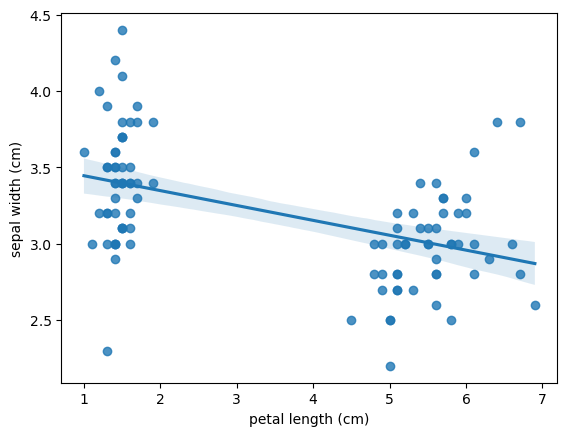

In [16]:
petallen = df['petal length (cm)'].astype(float)

sns.regplot(x=petallen, y=sepalwid)

plt.show()

Получили ситуацию, аналогичную прошлому подпункту, у нас нет ярко-выраженной корреляции. Будем действовать по тому же алгоритму.

Выдвинем гипотезу о нормальности распределния PETALLEN, для ее подтверждения или опровержения построим гистограмму.

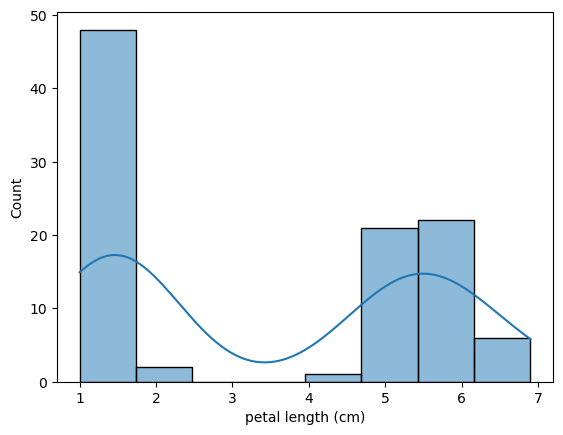

In [17]:
sns.histplot(petallen, kde='r')

plt.show()

Видно, что ничего общего с нормальным распределением данная гистограмма не имеет, и уже сейчас можно отклонить гипотезу о нормальности распределния PETALLEN. Для подтверждения этого факта построим график "квантиль-квантиль".

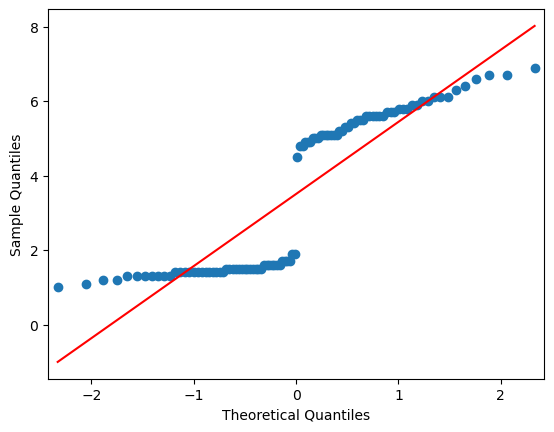

In [18]:
fig = sm.qqplot(petallen, line='r')

plt.show()

Видно, что значения мало того, что не лежат на линии нормального распределния, так еще имеют некоторую "пропасть", свидетельствующую о разделении на кластеры.

Проверим критерии

In [19]:
print(kstest(petallen, 'norm'))
print(scipy.stats.shapiro(petallen))
print(scipy.stats.chisquare(petallen))

KstestResult(statistic=0.8649303297782918, pvalue=3.066167865765482e-87, statistic_location=1.2, statistic_sign=-1)
ShapiroResult(statistic=0.7805752754211426, pvalue=6.53977913489534e-11)
Power_divergenceResult(statistic=123.92503564299972, pvalue=0.04572602442277413)


Все три критерия имеют p-значения < 0.05, что точно позволяет нам отклонить гипотезу о нормальности распределния переменной PETALLEN. Поэтому применим коэффициент корреляции Спирмена.

In [20]:
rho, p = spearmanr(petallen, sepalwid)

print('Spearman correlation coefficient:', rho)
print('Spearman P-value:', p)

Spearman correlation coefficient: -0.3761537388906749
Spearman P-value: 0.00011483558688011132


Значения коэффициента уже более весомо и свидетельствует об обратной зависимости. P-значение t-критерия < 0.05, поэтому истинный коэффициент корреляции не равен нулю.

#### Корреляция между SEPALWID и PETALLEN

Рассмотрим зависимость между переменными SEPALWID и PETALWID.

Для этого сначала построим диаграмму рассеяния для этих двух переменных.

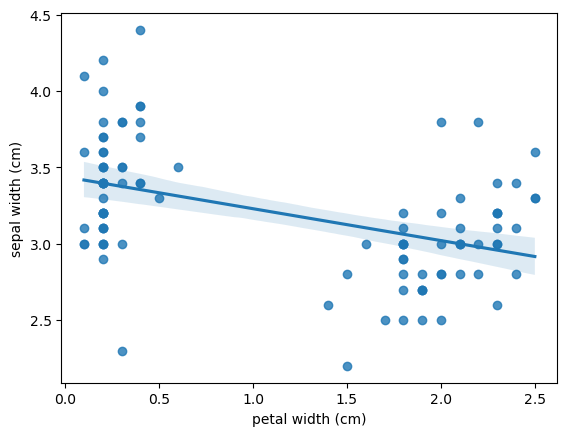

In [21]:
petalwid = df['petal width (cm)'].astype(float)

sns.regplot(x=petalwid, y=sepalwid)

plt.show()

Получили ситуацию, очень похожую на прошлый подпункт. Будем действовать по тому же алгоритму.

Выдвинем гипотезу о нормальности распределния PETALWID, для ее подтверждения или опровержения построим гистограмму.

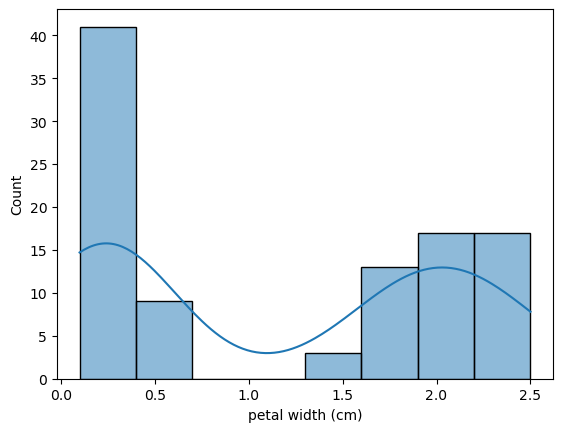

In [22]:
sns.histplot(petalwid, kde='r')

plt.show()

Видно, что ничего общего с нормальным распределением данная гистограмма не имеет, и уже сейчас можно отклонить гипотезу о нормальности распределния PETALWID. Для подтверждения этого факта построим график "квантиль-квантиль".

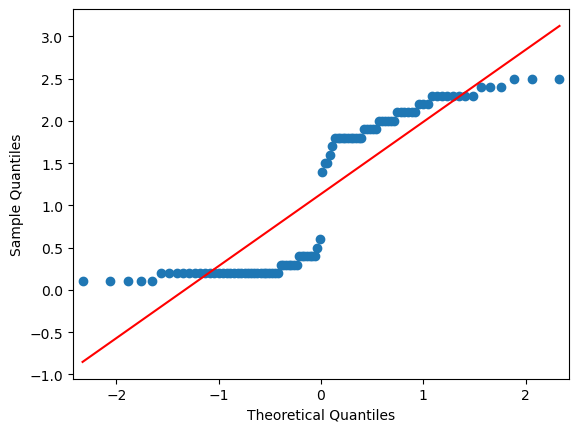

In [23]:
fig = sm.qqplot(petalwid, line='r')

plt.show()

Видно, что значения мало того, что не лежат на линии нормального распределния, так еще имеют некоторую "пропасть", свидетельствующую о разделении на кластеры.

Проверим критерии

In [24]:
print(kstest(petalwid, 'norm'))
print(scipy.stats.shapiro(petalwid))
print(scipy.stats.chisquare(petalwid))

KstestResult(statistic=0.539827837277029, pvalue=8.390376214701721e-28, statistic_location=0.1, statistic_sign=-1)
ShapiroResult(statistic=0.7883787155151367, pvalue=1.1055410753524342e-10)
Power_divergenceResult(statistic=73.45985915492959, pvalue=0.9744939821023966)


Два критерия имеют p-значения < 0.05, что точно позволяет нам отклонить гипотезу о нормальности распределния переменной PETALWID. Поэтому применим коэффициент корреляции Спирмена.

In [25]:
rho, p = spearmanr(petalwid, sepalwid)

print('Spearman correlation coefficient:', rho)
print('Spearman P-value:', p)

Spearman correlation coefficient: -0.35378703960296415
Spearman P-value: 0.0003051288575492674


Значения коэффициента свидетельствует об обратной зависимости. P-значение t-критерия < 0.05, поэтому истинный коэффициент корреляции не равен нулю.

### Регрессионный анализ

Проведем регрессионный анализ влияния факторов SEPALWID, SEPALLEN, PETALLEN и PETALWID для построения регрессионной модели для предсказания поведения зависимой переменной SEPALLEN.

Построим корреляционную таблицу с коэффициентами Спирмена.

In [26]:
corr = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].astype(float).corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.233141,0.878203,0.820884
sepal width (cm),-0.233141,1.000000,-0.376154,-0.353787
petal length (cm),0.878203,-0.376154,1.000000,0.838575
petal width (cm),0.820884,-0.353787,0.838575,1.000000


Из этой таблицы видно, что сильной связью обладают независимые переменные, что необходимо будет учесть при построении регрессионной модели.

Начнем построение нашей модели с таблицы уровней значимости. 

In [27]:
import statsmodels.api as sm

x, y = df[['sepal length (cm)', 'petal length (cm)', 'petal width (cm)']].astype(float), df['sepal width (cm)'].astype(float)
x = sm.add_constant (x)

model = sm. OLS (y, x). fit ()
print(model. summary ())

                            OLS Regression Results                            
Dep. Variable:       sepal width (cm)   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     39.77
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           8.57e-17
Time:                        23:52:46   Log-Likelihood:                -13.753
No. Observations:                 100   AIC:                             35.51
Df Residuals:                      96   BIC:                             45.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0716      0.31

Здесь видно, что все факторы имеют влияение на переменную SEPALWID, но следует помнить о сильной зависимости между независимыми переменными SEPALLEN, PETALLEN и PETALWID. Выбросим из нашей модели ту переменную, которая оказывает наименьшее влияние на переменную, то есть PETALWID.

In [28]:
x, y = df[['sepal length (cm)', 'petal length (cm)']].astype(float), df['sepal width (cm)'].astype(float)
x = sm.add_constant (x)

model = sm. OLS (y, x). fit ()
print(model. summary ())

                            OLS Regression Results                            
Dep. Variable:       sepal width (cm)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     51.97
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           4.56e-16
Time:                        23:52:46   Log-Likelihood:                -17.726
No. Observations:                 100   AIC:                             41.45
Df Residuals:                      97   BIC:                             49.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1505      0.32

Помним про зависимость между SEPALLEN и PETALLEN и поступаем тем же образом, удаляя переменную PETALLEN.

In [29]:
x, y = df[['sepal length (cm)']].astype(float), df['sepal width (cm)'].astype(float)
x = sm.add_constant (x)

model = sm. OLS (y, x). fit ()
print(model. summary ())

                            OLS Regression Results                            
Dep. Variable:       sepal width (cm)   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.858
Date:                Sun, 24 Dec 2023   Prob (F-statistic):             0.0299
Time:                        23:52:46   Log-Likelihood:                -51.722
No. Observations:                 100   AIC:                             107.4
Df Residuals:                      98   BIC:                             112.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.7579      0.25

Получили модель вида 
sepalwid = 3.7579 - 0.0961*sepallen

Для оценки качества модели проведем анализ остатков на нормальность. Построим гистограмму распределения для остатков.

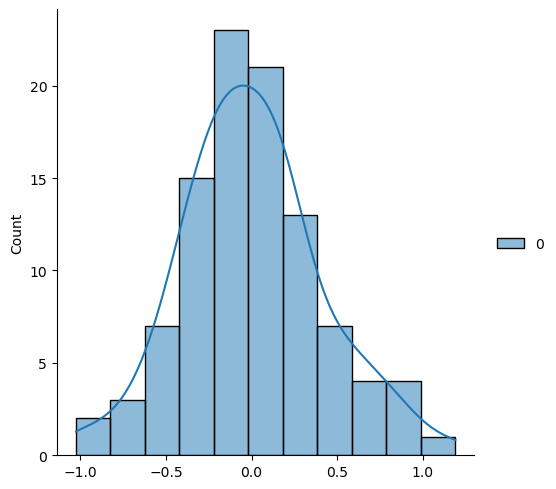

In [30]:
raw_residuals = model.resid

sns.displot(pd.DataFrame(raw_residuals), kde=True)
plt.show()

По графику видно, что мы имеем практически идеальную гистограмму для нормального распределения. Построим график "квантиль-квантиль".

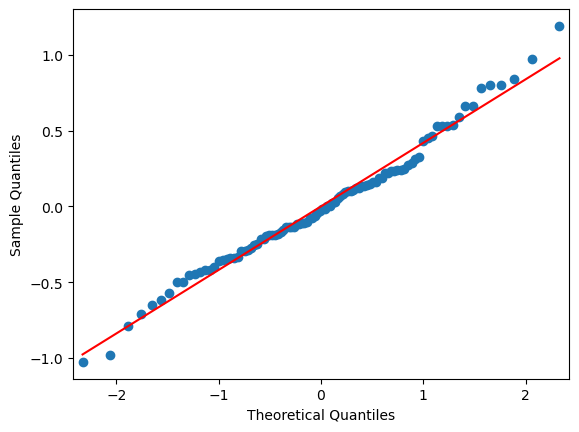

In [31]:
fig = sm.qqplot(raw_residuals, line='r')
plt.show()

Из графика видно, что большинство значений лежит на линии нормального распределния с некоторыми отклонениями на концах. Что дает нам подтвердить гипотезу о нормальности распределния остатков.

Построим на диаграмму рассеяния остатков и предсказанных моделью значений.

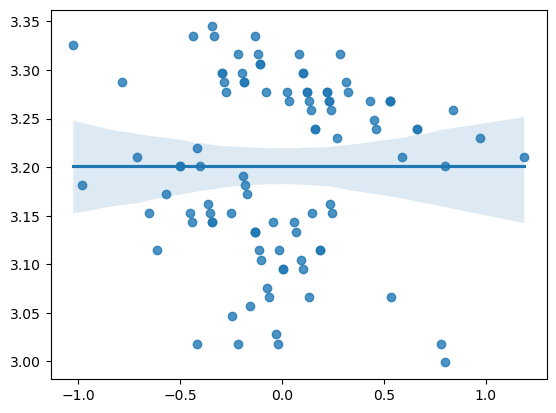

In [32]:
sns.regplot(x = raw_residuals, y = model.predict())

plt.show()

Заметно отсутствие какой-либо зависимости между остатками и предсказанными значениями.

Рассмотрим приемлимость модели в целом, для этого построим таблицу ANOVA.

In [33]:
df_ren = df.rename(columns={'sepal width (cm)': 'sepalwid', 'sepal length (cm)': 'sepallen', 'petal length (cm)': 'petallen', 'petal width (cm)':'petalwid'})

model = sm.formula.ols('sepalwid ~ sepallen', data=df_ren[['sepallen', 'sepalwid', 'petallen', 'petalwid']].astype(float)).fit()
anovatable = sm.stats.anova_lm(model, typ=2)

print(anovatable)

raw_residuals = model.resid

             sum_sq    df         F    PR(>F)
sepallen   0.816612   1.0  4.858043  0.029858
Residual  16.473288  98.0       NaN       NaN


Поскольку Р-уровень значимости меньше 0.05, то мы можем утверждать, что наша модель приемлема и будет работать лучше, чем наивный прогноз по средним значениям.
Коэффициент детерминации R-squared = 0,047, значит примерно 4,7% факторов мы учли в своей модели. Что не является достаточно хорошим показателем. Посмотрим, чему равен средний квадрат ошибки полученной модели.

In [34]:
x, y = df[['sepal length (cm)']].astype(float), df['sepal width (cm)'].astype(float)
x = sm.add_constant (x)

model = sm. OLS (y, x). fit ()

y_pred = model.predict(x)

print(sklearn.metrics.mean_squared_error(y, y_pred))

0.16473288323267674


Интересно сравнить это значение с тем, если бы мы не удаляли переменную PETALLEN из модели. Вернемся к моменту построения нашей модели и оставим PETALLEN.

In [35]:
x, y = df[['sepal length (cm)', 'petal length (cm)']].astype(float), df['sepal width (cm)'].astype(float)
x = sm.add_constant (x)

model = sm. OLS (y, x). fit ()
print(model. summary ())

                            OLS Regression Results                            
Dep. Variable:       sepal width (cm)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     51.97
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           4.56e-16
Time:                        23:52:46   Log-Likelihood:                -17.726
No. Observations:                 100   AIC:                             41.45
Df Residuals:                      97   BIC:                             49.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1505      0.32

Получили модель вида 
sepalwid = 1.1505 + 0.5480*sepallen - 0.3212*petallen

Для оценки качества модели проведем анализ остатков на нормальность. Построим гистограмму распределения для остатков.

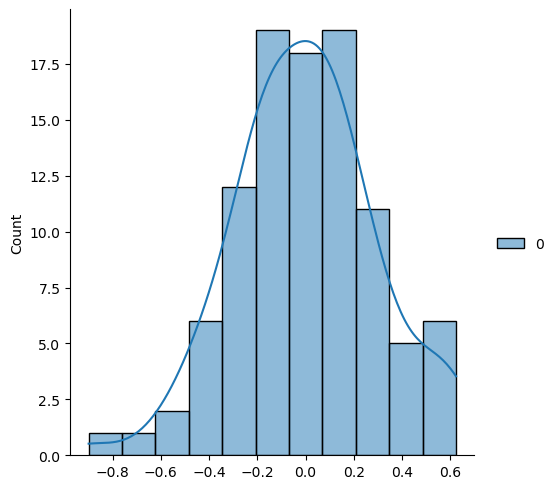

In [36]:
raw_residuals = model.resid

sns.displot(pd.DataFrame(raw_residuals), kde=True)
plt.show()

В целом, гистограмма выглядит неплохо, но имеет небольшое смещение вправо. Построим график "квантиль-квантиль".

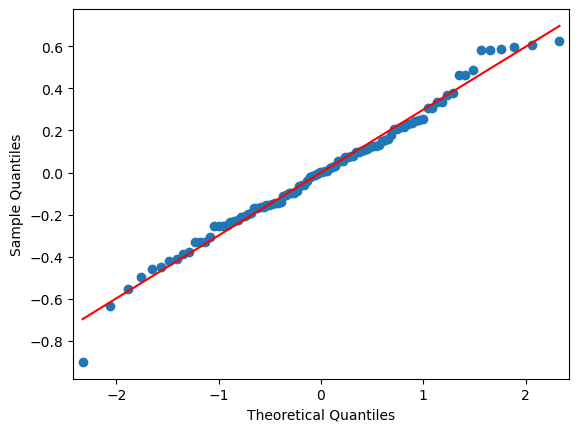

In [37]:
fig = sm.qqplot(raw_residuals, line='r')
plt.show()

Я бы сказал, что ситуация на этом графике даже лучше, чем на прошлой модели, но она не лишена недостатков в виде отклонения на концах.

Подтверждаем гипотезу о нормальности распределения остатков и посмотрим на диаграмму рассеяния остатков и предсказанных моделью значений.

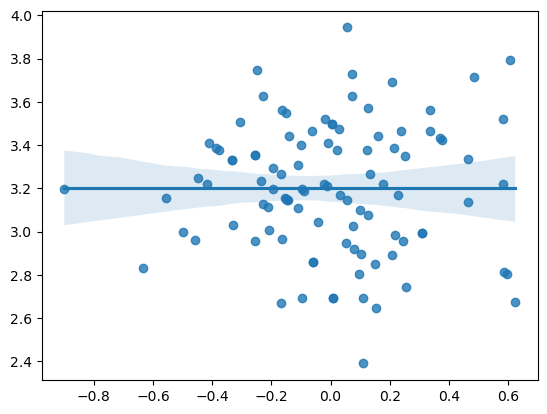

In [38]:
sns.regplot(x = raw_residuals, y = model.predict())

plt.show()

Заметно отсутствие какой-либо зависимости между остатками и предсказанными значениями.

Рассмотрим приемлимость модели в целом, для этого построим таблицу ANOVA.

In [39]:
df_ren = df.rename(columns={'sepal width (cm)': 'sepalwid', 'sepal length (cm)': 'sepallen', 'petal length (cm)': 'petallen', 'petal width (cm)':'petalwid'})

model = sm.formula.ols('sepalwid ~ sepallen', data=df_ren[['sepallen', 'sepalwid', 'petallen', 'petalwid']].astype(float)).fit()
anovatable = sm.stats.anova_lm(model, typ=2)

print(anovatable)

raw_residuals = model.resid

             sum_sq    df         F    PR(>F)
sepallen   0.816612   1.0  4.858043  0.029858
Residual  16.473288  98.0       NaN       NaN


Поскольку Р-уровень значимости меньше 0.05, то мы можем утверждать, что наша модель приемлема и будет работать лучше, чем наивный прогноз по средним значениям.
Коэффициент детерминации R-squared = 0,517, значит примерно 52% факторов мы учли в своей модели, что значительно лучше значения для прошлой модели. Посмотрим, чему равен средний квадрат ошибки полученной модели.

In [40]:
x = df[['sepal length (cm)', 'petal width (cm)']].astype(float)
y = df['sepal width (cm)'].astype(float)

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

y_pred = model.predict(x)

print(sklearn.metrics.mean_squared_error(y, y_pred))

0.11735902671139867


Средний квадрат ошибки здесь меньше, что, учитывая еще значение R-squared, говорит о том, что эта модель лучше работает для предсказания значения переменной SEPALWID.